In [37]:
import torch
import torch.nn as nn
from typing import Optional
import matplotlib.pyplot as plt

In [38]:
class MyPlannerTransformer(nn.Module):
    def __init__(self, num_features=6, numOfEncoderLayers = 6, numOfDecoderLayers=6) -> None:
        super().__init__()
        self.transformer_model = nn.Transformer(
            d_model=num_features,
            nhead=1,
            num_encoder_layers=numOfEncoderLayers,
            num_decoder_layers=numOfDecoderLayers,
            dim_feedforward=2048,
            dropout=0.1,
        )
        # map tgt to have the same number of features as src
        self.tgt = nn.Linear(2, num_features)

    def forward(
        self,
        src: torch.tensor,
        tgt: torch.tensor,
        src_mask: Optional[torch.tensor]=None,
        tgt_mask: Optional[torch.tensor]=None,
        memory_mask: Optional[torch.tensor]=None,
        src_key_padding_mask: Optional[torch.tensor]=None,
        tgt_key_padding_mask: Optional[torch.tensor]=None,
        memory_key_padding_mask: Optional[torch.tensor]=None,
        max_len: Optional[int]=None,
        
    )->torch.tensor:
        tgt = self.tgt(tgt)
        out = self.transformer_model(src, tgt)
        return out[:,:2]
    
    def predict(self, src: torch.tensor, tgt: torch.tensor, max_len: Optional[int]=None)->torch.tensor:
        self.eval()
        with torch.no_grad():
            prediction = self.forward(src, tgt)
        return prediction
    
    

In [39]:
#batch_size = 10
src = torch.load('../inputs/tensors/src.pt')
tgt = torch.load('../inputs/tensors/tgt.pt')

In [40]:
src.shape, tgt.shape

(torch.Size([694, 5]), torch.Size([356, 2]))

In [41]:
model = MyPlannerTransformer(num_features=5)
#model.forward(src, tgt).shape

In [42]:
#model(src, tgt)

In [43]:
# import torch data loader
from torch.utils.data import DataLoader

src_train_loader = DataLoader(src, batch_size=10, shuffle=True)
tgt_train_loader = DataLoader(tgt, batch_size=10, shuffle=True)


In [44]:
def trainModel(model, src_loader, tgt_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    LOSS = []
    for epoch in range(epochs):
        COST = 0
        for src_batch, tgt_batch in zip(src_loader, tgt_loader):
            optimizer.zero_grad()
            prediction = model(src_batch, tgt_batch)
            loss = criterion(prediction, tgt_batch)
            loss.backward()
            COST += loss.item()
            optimizer.step()
        avg_loss = COST / len(src_loader)
        LOSS.append(avg_loss)
        print(f'Epoch: {epoch+1}, Total Loss: {avg_loss}')
    return LOSS

train_loss =trainModel(model, src_train_loader, tgt_train_loader, epochs=50)

Epoch: 1, Total Loss: 514.3170907156808
Epoch: 2, Total Loss: 503.54964425223216
Epoch: 3, Total Loss: 506.97543160574776
Epoch: 4, Total Loss: 503.28922206333704
Epoch: 5, Total Loss: 497.2796273367746
Epoch: 6, Total Loss: 496.37208775111606
Epoch: 7, Total Loss: 488.83615155901225
Epoch: 8, Total Loss: 489.00770307268414
Epoch: 9, Total Loss: 489.57657209123886
Epoch: 10, Total Loss: 482.95596662248886
Epoch: 11, Total Loss: 483.76427873883927
Epoch: 12, Total Loss: 480.0649640764509
Epoch: 13, Total Loss: 479.4048156738281
Epoch: 14, Total Loss: 477.0506958007812
Epoch: 15, Total Loss: 479.7829262869699
Epoch: 16, Total Loss: 476.7278782435826
Epoch: 17, Total Loss: 473.5440691266741
Epoch: 18, Total Loss: 470.0486572265625
Epoch: 19, Total Loss: 469.3988830566406
Epoch: 20, Total Loss: 467.7588178362165
Epoch: 21, Total Loss: 468.6115012032645
Epoch: 22, Total Loss: 464.8545187813895
Epoch: 23, Total Loss: 465.56981593540735
Epoch: 24, Total Loss: 461.2034441266741
Epoch: 25, Tota

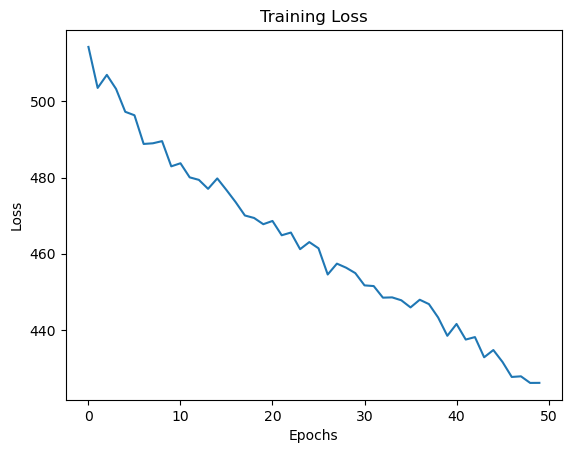

In [45]:
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [46]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [47]:
# load model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [48]:
# predict
yhat = model.predict(src, tgt)